## Load necessities 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients, DeepLift, Saliency
from explainable_ai_image_measures import Measures
import time
from shap.datasets import imagenet50
import torchvision.models as models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.googlenet(pretrained=True).to(device)
model.eval()
print("Model loaded")

Model loaded


In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
        
raw_images, labels = imagenet50()
images = raw_images.copy() / 255
images = (images - mean) / std

images = torch.FloatTensor(images).permute(0, 3, 1, 2)
labels = torch.Tensor(labels)

## Evaluate a single image

In [4]:
id = 1
image = images[id:id+1].to(device)
raw_image = raw_images[id:id+1]

result = F.softmax(model(image), dim=1)
prob, label = torch.topk(result, 1)

In [5]:
sal = Saliency(model)
attribution = sal.attribute(image, target=label.item())

Input Tensor 0 did not already require gradients, required_grads has been set automatically.


Visual result for the image: 


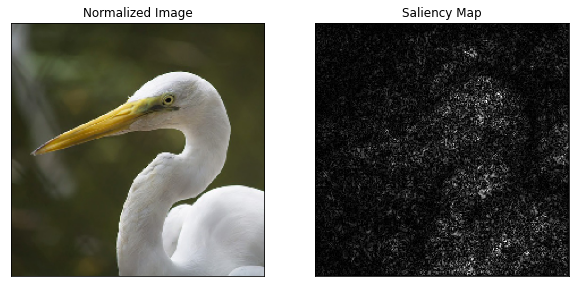

In [6]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(raw_image[0].astype(np.uint))
plt.title("Normalized Image")
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(attribution[0,0].cpu(), cmap="gray", interpolation="none")
plt.title(f"Saliency Map")
plt.xticks([])
plt.yticks([])

print("Visual result for the image: ")
plt.show()

In [11]:
measure = Measures(model, pixel_package_size=5, irof_segments=100, batch_size=50)
DAUC_score, DAUC_y = measure.compute_DAUC(image[0], attribution[0,0], label)
IAUC_score, IAUC_y = measure.compute_IAUC(image[0], attribution[0,0], label)
IROF_score, IROF_y = measure.compute_IROF(image[0], attribution[0,0], label)

Here the scoring results: 


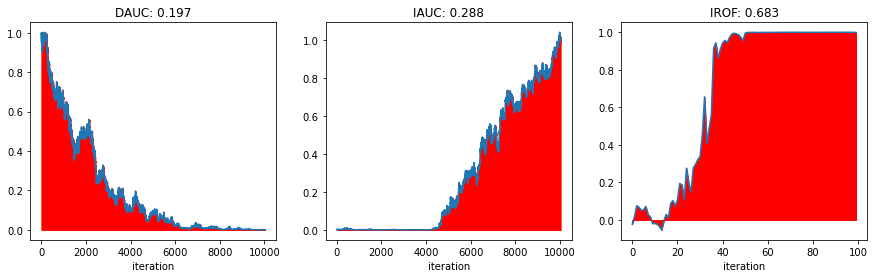

In [8]:
fig = plt.figure(figsize=(15, 4))

x = np.arange(len(DAUC_y))
plt.subplot(1, 3, 1)
plt.plot(x, DAUC_y.cpu().numpy())
plt.fill_between(x, 0, DAUC_y.cpu().numpy(), color="red")
plt.title(f"DAUC: {DAUC_score:.3f}")
plt.xlabel("iteration")

plt.subplot(1, 3, 2)
plt.plot(IAUC_y.cpu().numpy())
plt.fill_between(x, 0, IAUC_y.cpu().numpy(), color="red")
plt.title(f"IAUC: {IAUC_score:.3f}")
plt.xlabel("iteration")

x = np.arange(len(IROF_y))
plt.subplot(1, 3, 3)
plt.plot(IROF_y.cpu().numpy())
plt.fill_between(x, 0, IROF_y.cpu().numpy(), color="red")
plt.title(f"IROF: {IROF_score:.3f}")
plt.xlabel("iteration")

print("Here the scoring results: ")

**Delete Area Under curve**: A *smaller* area under the curve is better

**Insert Area Under curve, IROF**: A *larger* area under the curve is better


## Evaluate multiple attributions for multiple images

In [9]:
start_id = 0
length = 5
image_batch = images[start_id:length].to(device)
raw_image_batch = raw_images[start_id:length]

result = F.softmax(model(image_batch), dim=1)
probs, labels = torch.topk(result, 1)

sal_attributions = sal.attribute(image_batch, target=labels.flatten()).squeeze(1)

methods = ["Saliency", "DeepLift"]
dl = DeepLift(model)
dl_attributions = dl.attribute(image_batch, target=labels.flatten()).squeeze(1)

attributions = torch.stack([sal_attributions, dl_attributions]).permute(1, 0, 2, 3, 4)

# Average over color channel to get attribution scores per pixel
attributions = torch.mean(attributions, dim=2)

print("Attributions shape: ", attributions.shape)
print("Images shape: ", image_batch.shape)


Attributions shape:  torch.Size([5, 2, 224, 224])
Images shape:  torch.Size([5, 3, 224, 224])


Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


In [12]:
start = time.time()
scoring_results = measure.compute_batch(image_batch, attributions, labels, IAUC=False)
end = time.time()

print(f"It took {(end-start):.2f} seconds to compute IROF and DAUC for {len(image_batch)} images with each {len(attributions)} attributions and {len(scoring_results.keys())} scores")

It took 260.72 seconds to compute IROF and DAUC for 5 images with each 5 attributions and 2 scores


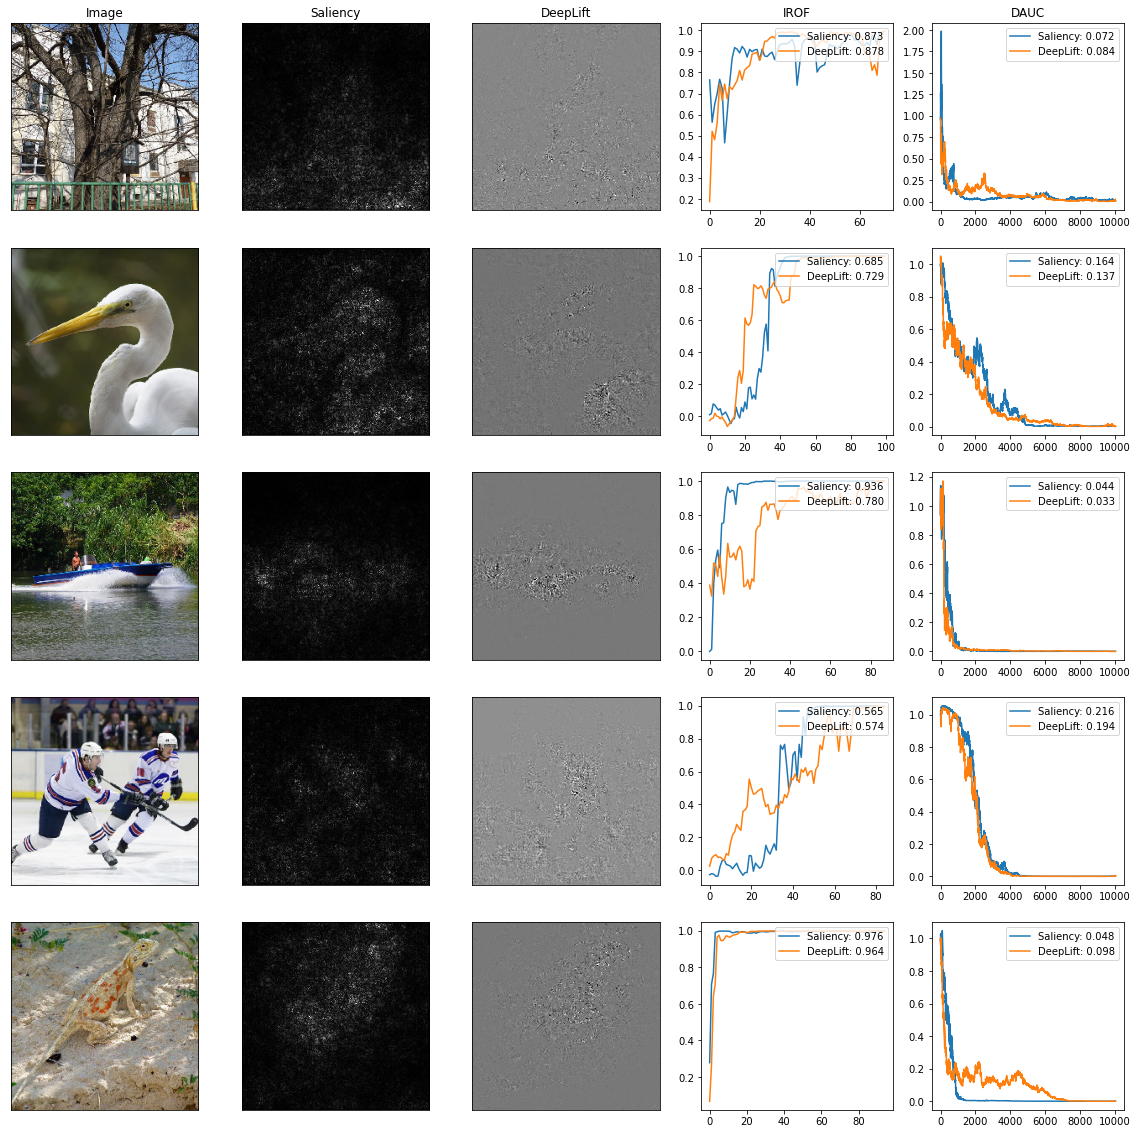

In [13]:
figure, axes = plt.subplots(nrows=(len(image_batch)), ncols=5, figsize=(20,20))
axes[0, 0].set_title("Image")

for img_id in range(len(image_batch)):
    axes[img_id, 0].imshow(raw_image_batch[img_id].astype(int))
    
    axes[img_id, 0].set_xticks([])
    axes[img_id, 0].set_yticks([])

    for method in range(attributions.shape[1]):
        method_name = methods[method]

        attribution = attributions[img_id, method].detach().cpu().numpy()
        axes[img_id, 1+method].imshow(attribution, cmap="gray", interpolation="none")
        axes[0, 1+method].set_title(method_name)
        axes[img_id, 1+method].set_xticks([])
        axes[img_id, 1+method].set_yticks([])

        for measure_id, measure_title in enumerate(scoring_results.keys()):
            ax = axes[img_id, 1+measure_id+attributions.shape[1]]
            score = scoring_results[measure_title][0][img_id, method].item()
            ax.plot(
                scoring_results[measure_title][1][img_id][method].cpu().numpy(),
                label=f"{method_name}: {score:.3f}"
            )
            axes[0, 1+measure_id+attributions.shape[1]].set_title(measure_title)
            ax.legend(loc="upper right")

## Speed up computation

The previous computation required over $100,000$ (at least $5 * 2 * 224 * 224 * 2 / 5$) images being evaluated just to compute DAUC. That's why it took so long. Let's reduce *pixel_package_size* to speed it up. The differences are on the third digit. 

In [15]:
measure = Measures(model, pixel_package_size=50, irof_segments=100, batch_size=50)
start = time.time()
scoring_results = measure.compute_batch(image_batch, attributions, labels, IAUC=False)
end = time.time()
print(f"It took {(end-start):.2f} seconds to compute IROF and DAUC for {len(image_batch)} images with each {len(attributions)} attributions and {len(scoring_results.keys())} scores")

It took 29.03 seconds to compute IROF and DAUC for 5 images with each 5 attributions and 2 scores


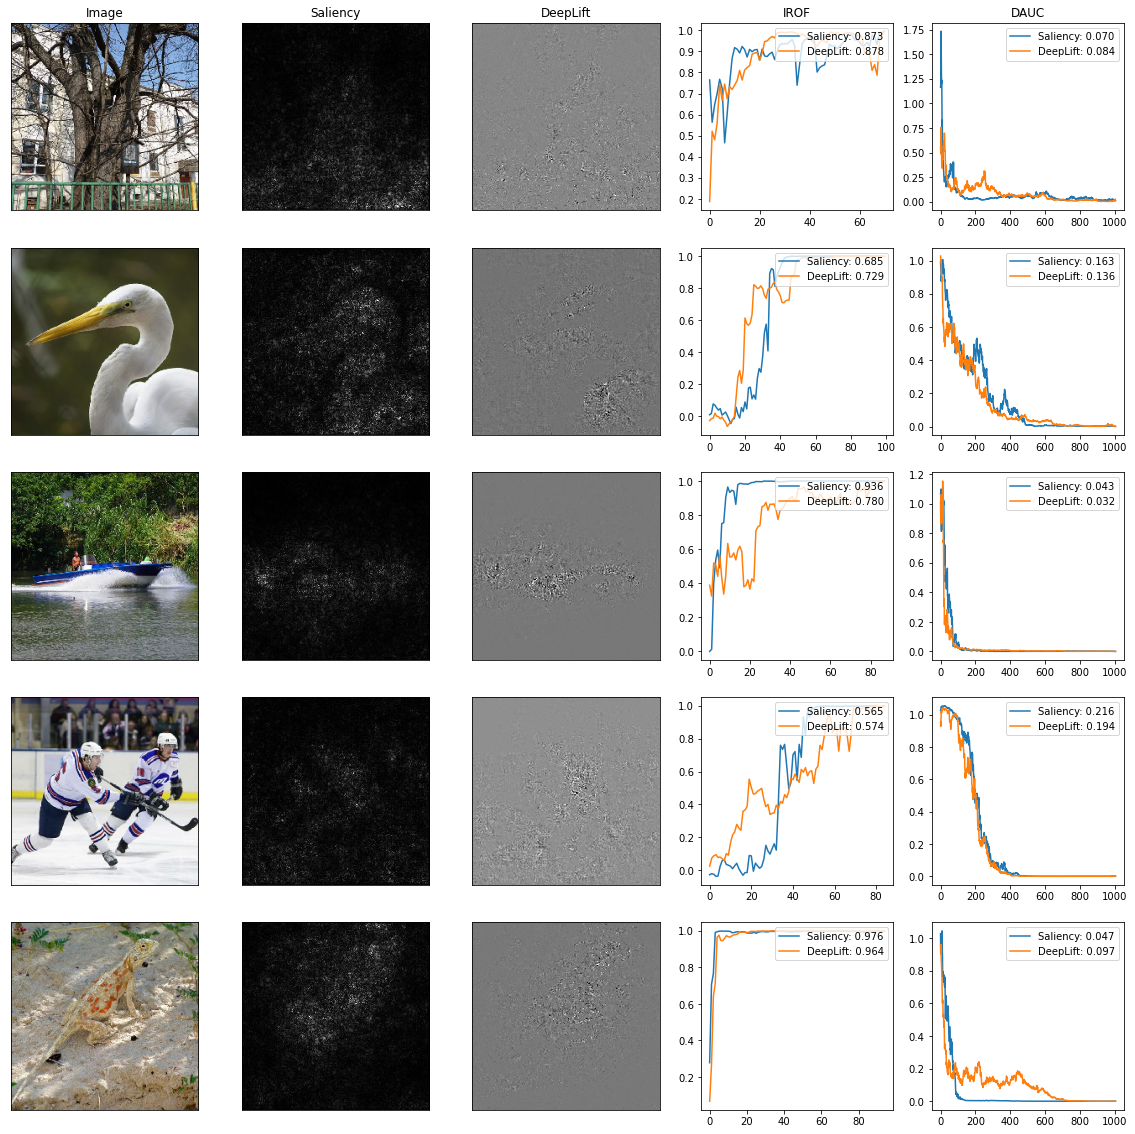

In [16]:
figure, axes = plt.subplots(nrows=(len(image_batch)), ncols=5, figsize=(20,20))
axes[0, 0].set_title("Image")

for img_id in range(len(image_batch)):
    axes[img_id, 0].imshow(raw_image_batch[img_id].astype(int))
    
    axes[img_id, 0].set_xticks([])
    axes[img_id, 0].set_yticks([])

    for method in range(attributions.shape[1]):
        method_name = methods[method]

        attribution = attributions[img_id, method].detach().cpu().numpy()
        axes[img_id, 1+method].imshow(attribution, cmap="gray", interpolation="none")
        axes[0, 1+method].set_title(method_name)
        axes[img_id, 1+method].set_xticks([])
        axes[img_id, 1+method].set_yticks([])

        for measure_id, measure_title in enumerate(scoring_results.keys()):
            ax = axes[img_id, 1+measure_id+attributions.shape[1]]
            score = scoring_results[measure_title][0][img_id, method].item()
            ax.plot(
                scoring_results[measure_title][1][img_id][method].cpu().numpy(),
                label=f"{method_name}: {score:.3f}"
            )
            axes[0, 1+measure_id+attributions.shape[1]].set_title(measure_title)
            ax.legend(loc="upper right")